In [1]:
import numpy as np
import scipy as sp
import corner
import emcee
from tqdm import tqdm
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Definitions

In [2]:
def correlation_matrix(m):
    """Calculates the correlation matrix of matrix m_ij."""
    avg = np.average(m, axis=0)
    dim = len(avg)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VARIATION
    sigma = []
    for i in range(dim):
        sigma.append(np.sum((avg[i] - m[i])**2))
    sigma = np.sqrt(sigma)
    
    sigma_bis = []
    for i in range(dim):
        cum = 0
        for j in range(len(m[i])):
            cum += (avg[i] - m[i][j])**2
        sigma_bis.append(cum)
    sigma_bis = np.sqrt(sigma_bis)        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CORRELATION MATRIX
    CORR = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            cum = 0
            for k in range(len(m[i])):
                cum += (avg[i] - m[i][k])*(avg[j] - m[j][k])
            CORR[i, j] = cum  / (sigma_bis[i] * sigma_bis[j])

    if np.linalg.det(CORR) == 0:
        print("¶ WARNING: correlation matrix is singular")
    
    return CORR

def Hartlap(mat, Nr = 350):
    """Calculates inverse matrix using Hartlap correction.
    Arguments:
    - `mat`: input matrix to invert
    - `Nr`: nuber of realization used o calculated the matrix
    """
    return (Nr-len(mat)-2)/(Nr-1)*np.linalg.inv(mat)

def info_name(name):
    """Obtain realization information from namefile"""
    print("TYPE: ", type(name))
    info = name.split('_')[-3:]
    print("TYPE: ", info, "\n", type(info))
    info[2] = info[2].replace(".wst", "")
    N_hgrid = info[0]
    N_WSTgrid = info[1]
    n_realiz = info[2].replace(".wst", "")
    
    return [int(N_hgrid), int(N_WSTgrid), int(n_realiz)]

def cosmo_parser(name):
    """Obtain cosmology from .wst file"""
    info = name.split('_')
    if info[0] == "fiducial":
        return info[0]
    elif info[0] == "zeldovich":
        return info[0]
    else:
        return info[0] + "_" + info[1]

In [3]:
order_folders = {
    'fiducial'  : 0,
    'h_m'       : 1,
    'h_p'       : 2,
    'Mnu_p'     : 3,
    'Mnu_pp'    : 4,
    'Mnu_ppp'   : 5,
    'ns_m'      : 6,
    'ns_p'      : 7,
    'Ob2_m'     : 8,
    'Ob2_p'     : 9,
    'Om_m'      : 10,
    'Om_p'      : 11,
    's8_m'      : 12,
    's8_p'      : 13,
    'w_m'       : 14,
    'w_p'       : 15,
    'zeldovich' : 16
}

cosmological_pars = {
    'Om'  : 0,
    'Ob'  : 1,
    'h'   : 2,
    'ns'  : 3,
    's8'  : 4,
    'w'   : 5,
    'Mnu' : 6
}

order_dimension = {
    'Om'  : 0,
    'Om ' : 0,
    'Ob'  : 1,
    'Ob ' : 1,
    'Ob2' : 1,
    'h'   : 2,
    'h  ' : 2,
    'ns'  : 3,
    'ns ' : 3,
    's8'  : 4,
    's8 ' : 4,
    'w'   : 5,
    'Mnu' : 6
}

COSMOPAR = {
#                   | Om   | Ob   |   h   |  n_s  | s_8 | Mnu | w |

    'fiducial' :    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'zeldovich':    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Mnu_p' :       [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.1, -1],
    'Mnu_pp' :      [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.2, -1],
    'Mnu_ppp' :     [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.4, -1],
    
    'h_m' :         [0.3175, 0.049, 0.6511, 0.9624, 0.834, 0, -1],
    'h_p' :         [0.3175, 0.049, 0.6911, 0.9624, 0.834, 0, -1],
    
    'ns_m' :        [0.3175, 0.049, 0.6711, 0.9424, 0.834, 0, -1],
    'ns_p' :        [0.3175, 0.049, 0.6711, 0.9824, 0.834, 0, -1],
    
    'Ob_m' :        [0.3175, 0.048, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob_p' :        [0.3175, 0.050, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_m' :       [0.3175, 0.047, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_p' :       [0.3175, 0.051, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Om_m' :        [0.3075, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'Om_p' :        [0.3275, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    's8_m' :        [0.3175, 0.049, 0.6711, 0.9624, 0.819, 0, -1],
    's8_p' :        [0.3175, 0.049, 0.6711, 0.9624, 0.849, 0, -1],
    
    'w_m' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -0.95],
    'w_p' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1.05]
}
"""
Dictionary to assegnate to a cosmology its parameters
Ordered pairing cosmologies and the first one in with _m, the second one _p
"""

VarCosmoPar = {
    'd_h'  : 0.02,
    'd_ns' : 0.02,
    'd_Ob' : 0.001,
    'd_Ob2': 0.002,
    'd_Om' : 0.01,
    'd_s8' : 0.015,
    'd_w'  : -0.05
}
"""Values of deviations from fiducial cosmological parameters.
"""

fiducial_vals = {
    'Ob'  : 0.3175,
    'Ob2' : 0.3175,
    'Om'  : 0.049,
    'h'   : 0.6711,
    'n_s' : 0.9624,
    'ns'  : 0.9624,
    's_8' : 0.834,
    's8'  : 0.834,
    'Mnu' : 0,
    'w'   : -1
}
"""Values of fiducial cosmological parameters.
"""

'Values of fiducial cosmological parameters.\n'

In [4]:
root = "/home/fuffolo97/TESI/WST-files_08_08/WST-files_08_08/"
folders = ['fiducial', 'zeldovich', 'h_m', 'h_p', 'Mnu_p', 'Mnu_pp' ,'Mnu_ppp', \
           'ns_m', 'ns_p', 'Ob2_m', 'Ob2_p', \
           'Om_m', 'Om_p', 's8_m', 's8_p', 'w_m', 'w_p']
cosmologies = ['fiducial', 'zeldovich', 'h_m', 'h_p', 'Mnu_p', 'Mnu_pp' ,'Mnu_ppp', \
           'ns_m', 'ns_p', 'Ob2_m', 'Ob2_p', \
           'Om_m', 'Om_p', 's8_m', 's8_p', 'w_m', 'w_p']
parameter_name = ['Om ', 'Ob ', 'h  ', 'ns ', 's8 ', 'w  ', 'Mnu']
fiducial_coeffs_N = []
fiducial_coeffs_RD = []
zeldovich_coeffs_N = []
zeldovich_coeffs_RD = []

# WST Coefficients

#### WST normal space Evaluation

In [5]:
coeffs_tot_N = np.zeros((len(cosmologies), 75))
files_to_read_raw = os.listdir(root)
files_to_read_N = []
for i in range(len(files_to_read_raw)):
    if "400" not in files_to_read_raw[i] and "_Ns_"  in files_to_read_raw[i]: files_to_read_N.append(files_to_read_raw[i])

for i in range(len(files_to_read_N)):
    coeffs_cosm = []
    file_reading = files_to_read_N[i]

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        # print("A, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    coeffs_cosm.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)

    elif "fiducial" in file_reading:
        # print("B, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    fiducial_coeffs_N.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_coeffs_N_avg = np.average(fiducial_coeffs_N, axis=0)

        print(np.shape(fiducial_coeffs_N_avg))
        
        if len(fiducial_coeffs_N) == 0:
            print(cosmo, " has problem!")

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    zeldovich_coeffs_N.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(zeldovich_coeffs)
        zeldovich_coeffs_N_avg = np.average(zeldovich_coeffs_N, axis=0)
        # print(zeldovich_coeffs_avg)
        print(np.shape(zeldovich_coeffs_N_avg))
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(coeffs_cosm) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(coeffs_cosm))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        coeffs_tot_N[index] = np.average(coeffs_cosm, axis=0)

(75,)
(75,)


#### WST Redshift Space evaluation

In [6]:
coeffs_tot_RD = np.zeros((len(cosmologies), 75))
files_to_read_raw = os.listdir(root)
files_to_read_RD = []
for i in range(len(files_to_read_raw)):
    if "400" not in files_to_read_raw[i] and "_RDs_" in files_to_read_raw[i]: files_to_read_RD.append(files_to_read_raw[i])

for i in range(len(files_to_read_RD)):
    coeffs_cosm = []
    file_reading = files_to_read_RD[i]

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        # print("A, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    coeffs_cosm.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)

    elif "fiducial" in file_reading:
        # print("B, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    fiducial_coeffs_RD.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_coeffs_RD_avg = np.average(fiducial_coeffs_RD, axis=0)

        print(np.shape(fiducial_coeffs_RD_avg))
        
        if len(fiducial_coeffs_RD) == 0:
            print(cosmo, " has problem!")

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    zeldovich_coeffs_RD.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(zeldovich_coeffs)
        zeldovich_coeffs_RD_avg = np.average(zeldovich_coeffs_RD, axis=0)
        # print(zeldovich_coeffs_avg)
        print(np.shape(zeldovich_coeffs_RD))
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(coeffs_cosm) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(coeffs_cosm))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        coeffs_tot_RD[index] = np.average(coeffs_cosm, axis=0)

(500, 75)
(75,)


### Derivates

In [7]:
derivates_N = np.zeros((len(cosmological_pars), len(coeffs_tot_N[0])))
derivates_RD = np.zeros((len(cosmological_pars), len(coeffs_tot_RD[0])))
n_seen = 0

In [8]:
for i in cosmological_pars:
    if "Mnu" not in i and "Ob" not in i:
        ind = order_dimension[i]
        derivates_N[ind]=(coeffs_tot_N[order_folders[i+"_p"]]-coeffs_tot_N[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )
        assert derivates_N[order_dimension[i]].all() > 1e-3, f"Derivates of {i} is null"

    elif "Mnu" in i:
        # derivates[order_dimension['Mnu']] = \
        #     (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * coeffs_tot[order_folders['zeldovich']]) / (12 * COSMOPAR[i][5]) - \
        #     (coeffs_tot[order_folders["Mnu_pp"]] - 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * coeffs_tot[order_folders['zeldovich']]) / (COSMOPAR[i][5]) + \
        #     (coeffs_tot[order_folders["Mnu_ppp"]] - coeffs_tot[order_folders['zeldovich']]) / COSMOPAR[i][5]
        # derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * zeldovich_coeffs_avg) / (12 * COSMOPAR[i][5]) + \
        #     (-coeffs_tot[order_folders["Mnu_pp"]] + 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * zeldovich_coeffs_avg) / (COSMOPAR[i][5]) + \
        #     (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / COSMOPAR[i][5]
        derivates_N[order_dimension['Mnu']]  = (coeffs_tot_N[order_folders["Mnu_p"]]  - zeldovich_coeffs_N_avg)  / (0.1)
            # (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * zeldovich_coeffs_avg) / (12 * 0.1) + \
            # (-coeffs_tot[order_folders["Mnu_pp"]] + 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * zeldovich_coeffs_avg) / (2*0.1) + \
            # (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
        # derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
        assert derivates_N[order_dimension['Mnu']].all() > 1e-3, "Derivates of neutrino mass is null"
    elif "Ob" in i:
        derivates_N[order_dimension['Ob']] = \
            (coeffs_tot_N[order_folders[i+"2_p"]]-coeffs_tot_N[order_folders[i+"2_m"]]) \
              / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )
        assert derivates_N[order_dimension['Ob']].all() > 1e-3, "Derivates of Omaga barion is null"

In [9]:
for i in cosmological_pars:
    if "Mnu" not in i and "Ob" not in i:
        ind = order_dimension[i]
        derivates_RD[ind]=(coeffs_tot_RD[order_folders[i+"_p"]]-coeffs_tot_RD[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )
        # assert -1e-3 > derivates_RD[order_dimension[i]].all() > 1e-3, f"Derivates of {i} is null: \n{derivates_RD[ind]}"

    elif "Mnu" in i:
        # derivates[order_dimension['Mnu']] = \
        #     (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * coeffs_tot[order_folders['zeldovich']]) / (12 * COSMOPAR[i][5]) - \
        #     (coeffs_tot[order_folders["Mnu_pp"]] - 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * coeffs_tot[order_folders['zeldovich']]) / (COSMOPAR[i][5]) + \
        #     (coeffs_tot[order_folders["Mnu_ppp"]] - coeffs_tot[order_folders['zeldovich']]) / COSMOPAR[i][5]
        # derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * zeldovich_coeffs_avg) / (12 * COSMOPAR[i][5]) + \
        #     (-coeffs_tot[order_folders["Mnu_pp"]] + 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * zeldovich_coeffs_avg) / (COSMOPAR[i][5]) + \
        #     (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / COSMOPAR[i][5]
        derivates_RD[order_dimension['Mnu']] = (coeffs_tot_RD[order_folders["Mnu_p"]] - zeldovich_coeffs_RD_avg) / (0.1)
            # (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * zeldovich_coeffs_avg) / (12 * 0.1) + \
            # (-coeffs_tot[order_folders["Mnu_pp"]] + 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * zeldovich_coeffs_avg) / (2*0.1) + \
            # (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
        # derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
        assert derivates_RD[order_dimension['Mnu']].all() > 1e-3, "Derivates of neutrino mass is null"
    elif "Ob" in i:
        derivates_RD[order_dimension['Ob']] = \
            (coeffs_tot_RD[order_folders[i+"2_p"]]-coeffs_tot_RD[order_folders[i+"2_m"]]) \
              / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )
        assert derivates_RD[order_dimension['Ob']].all() > 1e-3, "Derivates of Omaga barion is null"

In [10]:
parameter_name = ['Om ', 'Ob ', 'h  ', 'ns ', 's8 ', 'w  ', 'Mnu']

CorrMat = correlation_matrix(fiducial_coeffs)
H = Hartlap(CorrMat, 1000)
Fish = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish[a, b] = np.sum(derivates[a] * H * derivates[b])

import scipy as sp
inverse = np.linalg.inv(Fi)
results = []
for i in range(len(inverse)):
    results.append(inverse[i, i])

corr = np.corrcoef(fiducial_coeffs)
H = Hartlap(CorrMat, 1000)
Fish = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish[a, b] = np.sum(derivates[a] * (H * derivates[b]))

inverse = np.linalg.inv(Fish)
results = []
for i in range(len(inverse)):
    results.append(inverse[i, i])

constrains = (sp.linalg.eig(inverse))[0]
constrains = constrains ** 0.5

for i in range(len(constrains)):
    print(parameter_name[i], ": ", constrains[i])

np.shape(corr)

np.linalg.det(Fish)

#### BEST PROPOSAL

In [11]:
fids_N  = np.array(fiducial_coeffs_N).transpose()
corr2_N  = np.corrcoef(fids_N)
cov2_N  = np.cov(fids_N)

H2_N  = Hartlap(cov2_N, 1000)
Fish2_N  = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish2_N[a, b]  = np.sum(derivates_N[a]  * (H2_N  * derivates_N[b]))

inverse2_N = np.linalg.inv(Fish2_N)
diagonal2_N_wst = []
for i in range(len(inverse2_N)):
    diagonal2_N_wst.append(np.abs(inverse2_N[i, i])**0.5)

for i in range(len(diagonal2_N_wst)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_wst[i]))

Om  :  0.00048376555688353314
Ob  :  0.002274492036696267
h   :  0.04047173717133039
ns  :  0.00984716348567532
s8  :  0.011980583633679608
w   :  0.10279398346263864
Mnu :  0.10271430899558716


In [12]:
fids_RD = np.array(fiducial_coeffs_RD).transpose()
corr2_RD = np.corrcoef(fids_RD)
cov2_RD = np.cov(fids_RD)

H2_RD = Hartlap(cov2_RD, 1000)
Fish2_RD = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish2_RD[a, b] = np.sum(derivates_RD[a] * (H2_RD * derivates_RD[b]))

inverse2_RD = np.linalg.inv(Fish2_RD)
diagonal2_RD_wst = []
for i in range(len(inverse2_RD)):
    diagonal2_RD_wst.append(np.abs(inverse2_RD[i, i])**0.5)

for i in range(len(diagonal2_RD_wst)):
    print(parameter_name[i], ": ", np.abs(diagonal2_RD_wst[i]))

Om  :  0.00016859525426012444
Ob  :  0.001197476433475289
h   :  0.0022908774242353983
ns  :  0.007993107056596357
s8  :  0.005774706117708466
w   :  0.07655061858818982
Mnu :  0.1276943031681706


##### diagonalizing

constrains2 = (sp.linalg.eig(inverse2))[0]
constrains2 = constrains2 ** 0.5

for i in range(len(constrains2)):
    print(parameter_name[i], ": ", constrains2[i])
print()
for i in range(len(constrains2)):
    print(parameter_name[i], ": ", np.abs(constrains2[i]))

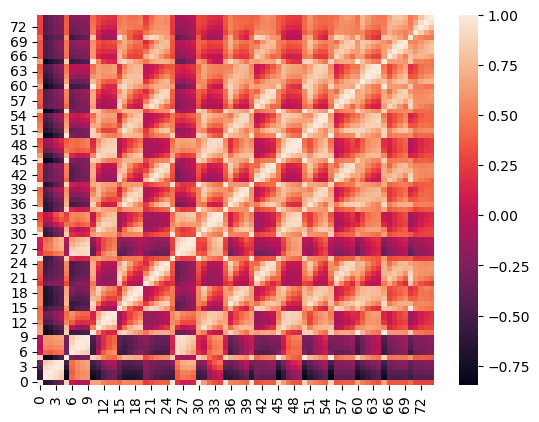

In [13]:
sns.heatmap(corr2_N.transpose())
plt.gca().invert_yaxis()

# plt.savefig('output_plot.pdf', format='pdf')

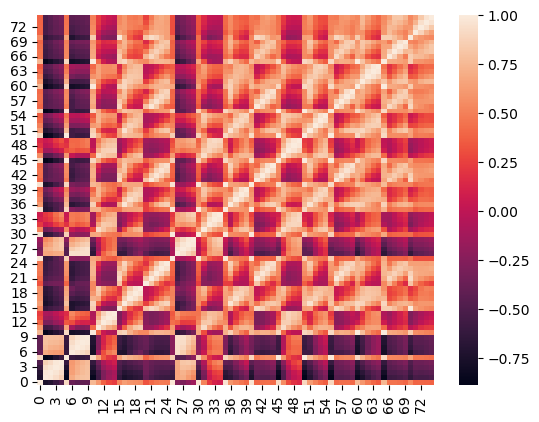

In [14]:
sns.heatmap(corr2_RD.transpose())
plt.gca().invert_yaxis()

# plt.savefig('output_plot.pdf', format='pdf')

# Power Spectrum

In [15]:
# root_pk = "../Pk-files_08_08/Pk-files_08_08/"
# root_pk = "/media/fuffolo97/HDD1/UNI/Tesi/Pk-files_08_08"
root_pk = "/media/fuffolo97/HDD1/UNI/Tesi/Pk-files_08_08"
files_to_read_raw_pk = os.listdir(root_pk)
n_seen = 0

#### Pk - Ns

In [16]:
files_to_read_N_pk = []

monos_tot_N_pk = np.zeros((len(cosmologies), 221))
quads_tot_N_pk = np.zeros((len(cosmologies), 221))
multi_tot_N_pk = np.zeros((len(cosmologies), 221*2))
fiducial_mono_N_coeffs = []
fiducial_quad_N_coeffs = []
fiducial_multi_N = []
zeldovich_mono_N_coeffs = []
zeldovich_quad_N_coeffs = []
zeldovich_multi_N = []


for i in range(len(files_to_read_raw_pk)):
    if "_Ns_" in files_to_read_raw_pk[i] and "400" not in  files_to_read_raw_pk[i] and "_Pk_M_" in files_to_read_raw_pk[i]: files_to_read_N_pk.append(files_to_read_raw_pk[i])

for i in range(len(files_to_read_N_pk)):
    coeffs_cosm_pk = []
    file_reading = files_to_read_N_pk[i]

    monopoles = []
    quadrupoles = []
    multipoles = []

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]

    assert (cosmo != "fiducial" and cosmo != "zeldovich") == (("fiducial" not in file_reading) and ("zeldovich" not in file_reading))
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    monopoles.append(a[:,0])
                    assert np.shape(a[:,0]) == (221,), f"it's {np.shape(a[:,0])}"
                    quadrupoles.append(a[:,1])
                    assert np.shape(a[:,1]) == (221,), f"it's {np.shape(a[:,1])}"

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    multipoles.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(np.shape(multipoles))
        assert np.shape(np.average(monopoles, axis=0)) == (221,)
        assert np.shape(np.average(quadrupoles, axis=0)) == (221,)
        assert np.shape(np.average(multipoles, axis=0)) == (442,)

    elif "fiducial" in file_reading:
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    fiducial_mono_N_coeffs.append(a[:,0])
                    fiducial_quad_N_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    fiducial_multi_N.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_mono_N_avg = np.average(fiducial_mono_N_coeffs, axis=0)
        fiducial_quad_N_avg = np.average(fiducial_quad_N_coeffs, axis=0)
        fiducial_multi_N_avg = np.average(fiducial_multi_N, axis=0)

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    zeldovich_mono_N_coeffs.append(a[:,0])
                    zeldovich_quad_N_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    zeldovich_multi_N.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        zeldovich_mono_N_avg = np.average(zeldovich_mono_N_coeffs, axis=0)
        zeldovich_quad_N_avg = np.average(zeldovich_quad_N_coeffs, axis=0)
        zeldovich_multi_N_avg = np.average(zeldovich_multi_N, axis=0)
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(monopoles) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(monopoles))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        #assert len(monopoles) == (221,), "wronng length for monopoles array"
        monos_tot_N_pk[index] = np.average(monopoles, axis=0)
        quads_tot_N_pk[index] = np.average(quadrupoles, axis=0)
        multi_tot_N_pk[index] = np.average(multipoles, axis=0)




#### Pk - RDs

In [17]:
files_to_read_RD_pk = []
monos_tot_RD_pk = np.zeros((len(cosmologies), 221))
quads_tot_RD_pk = np.zeros((len(cosmologies), 221))
multi_tot_RD_pk = np.zeros((len(cosmologies), 221*2))

fiducial_mono_RD_coeffs = []
fiducial_quad_RD_coeffs = []
fiducial_multi_RD = []
zeldovich_mono_RD_coeffs = []
zeldovich_quad_RD_coeffs = []
zeldovich_multi_RD = []

for i in range(len(files_to_read_raw_pk)):
    if "_RDs_" in files_to_read_raw_pk[i]  and "400" not in  files_to_read_raw_pk[i] and "_Pk_M_" in files_to_read_raw_pk[i]: files_to_read_RD_pk.append(files_to_read_raw_pk[i])

for i in range(len(files_to_read_RD_pk)):
    coeffs_cosm_pk = []
    file_reading = files_to_read_RD_pk[i]

    monopoles = []
    quadrupoles = []
    multipoles = []

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]

    assert (cosmo != "fiducial" and cosmo != "zeldovich") == (("fiducial" not in file_reading) and ("zeldovich" not in file_reading))
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        # print("A, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    monopoles.append(a[:,0])
                    assert np.shape(a[:,0]) == (221,), f"it's {np.shape(a[:,0])}"
                    quadrupoles.append(a[:,1])
                    assert np.shape(a[:,1]) == (221,), f"it's {np.shape(a[:,1])}"

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    multipoles.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(np.shape(multipoles))
        assert np.shape(np.average(monopoles, axis=0)) == (221,)
        assert np.shape(np.average(quadrupoles, axis=0)) == (221,)
        assert np.shape(np.average(multipoles, axis=0)) == (442,)

    elif "fiducial" in file_reading:
        # print("F, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    fiducial_mono_RD_coeffs.append(a[:,0])
                    fiducial_quad_RD_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    fiducial_multi_RD.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_mono_RD_avg = np.average(fiducial_mono_RD_coeffs, axis=0)
        fiducial_quad_RD_avg = np.average(fiducial_quad_RD_coeffs, axis=0)
        fiducial_multi_RD_avg = np.average(fiducial_multi_RD, axis=0)

    elif "zeldovich" in file_reading:
        # print("Z, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    zeldovich_mono_RD_coeffs.append(a[:,0])
                    zeldovich_quad_RD_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    zeldovich_multi_RD.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        zeldovich_mono_RD_avg = np.average(zeldovich_mono_RD_coeffs, axis=0)
        zeldovich_quad_RD_avg = np.average(zeldovich_quad_RD_coeffs, axis=0)
        zeldovich_multi_RD_avg = np.average(zeldovich_multi_RD, axis=0)
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(monopoles) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(monopoles))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        #assert len(monopoles) == (221,), "wronng length for monopoles array"
        monos_tot_RD_pk[index] = np.average(monopoles, axis=0)
        quads_tot_RD_pk[index] = np.average(quadrupoles, axis=0)
        multi_tot_RD_pk[index] = np.average(multipoles, axis=0)

assert np.shape(monos_tot_RD_pk[0]) == (221,)
assert np.shape(quads_tot_RD_pk[0]) == (221,)
assert np.shape(multi_tot_RD_pk[0]) == (442,)

#### Derivates Ns

In [18]:
derivates_multi_N_pk = np.zeros((len(cosmological_pars), len(multi_tot_N_pk[0])))

for i in cosmological_pars:
    if "Mnu" not in i and "Ob" not in i:
        ind = order_dimension[i]
        derivates_multi_N_pk[ind]=(multi_tot_N_pk[order_folders[i+"_p"]]-multi_tot_N_pk[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )
        #assert derivates_multi_N_pk[order_dimension[i]].all() > 1e-3, f"Derivates of {i} is null"

    elif "Mnu" in i:
        derivates_multi_N_pk[order_dimension['Mnu']] = (multi_tot_N_pk[order_folders["Mnu_p"]] - zeldovich_multi_N_avg) / (0.1)
        #assert derivates_multi_N_pk[order_dimension['Mnu']].all() > 1e-3, "Derivates of neutrino mass is null"

    elif "Ob" in i:
        derivates_multi_N_pk[order_dimension['Ob']] = \
            (multi_tot_N_pk[order_folders[i+"2_p"]]-multi_tot_N_pk[order_folders[i+"2_m"]]) \
              / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )
        #assert derivates_multi_N_pk[order_dimension['Ob']].all() > 1e-3, "Derivates of Omaga barion is null"

#### Derivates RDs

In [19]:
derivates_multi_RD_pk = np.zeros((len(cosmological_pars), len(multi_tot_N_pk[0])))

for i in cosmological_pars:
    if "Mnu" not in i and "Ob" not in i:
        ind = order_dimension[i]
        derivates_multi_RD_pk[ind]=(multi_tot_RD_pk[order_folders[i+"_p"]]-multi_tot_RD_pk[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )
        #assert derivates_multi_RD_pk[order_dimension[i]].all() > 1e-3, f"Derivates of {i} is null"

    elif "Mnu" in i:
        derivates_multi_RD_pk[order_dimension['Mnu']] = (multi_tot_RD_pk[order_folders["Mnu_p"]] - zeldovich_multi_RD_avg) / (0.1)
        #assert derivates_multi_RD_pk[order_dimension['Mnu']].all() > 1e-3, "Derivates of neutrino mass is null"

    elif "Ob" in i:
        derivates_multi_RD_pk[order_dimension['Ob']] = \
            (multi_tot_RD_pk[order_folders[i+"2_p"]]-multi_tot_RD_pk[order_folders[i+"2_m"]]) \
              / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )
        #assert derivates_multi_RD_pk[order_dimension['Ob']].all() > 1e-3, "Derivates of Omaga barion is null"

#### Fisher Ns

In [20]:
fids_N = np.array(fiducial_multi_N).transpose()
corr2_N = np.corrcoef(fids_N)
cov2_N = np.cov(fids_N)

H2_N = Hartlap(cov2_N, 1000)
Fish2_N = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish2_N[a, b] = np.sum(derivates_multi_N_pk[a] * (H2_N * derivates_multi_N_pk[b]))

inverse2_N = np.linalg.inv(Fish2_N)
diagonal2_N_multi = []
for i in range(len(inverse2_N)):
    diagonal2_N_multi.append(np.abs(inverse2_N[i, i])**0.5)

for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_multi[i]))

Om  :  0.001085159091785942
Ob  :  0.005884952467797716
h   :  0.13516889853198566
ns  :  0.11702939066897243
s8  :  0.0645107729776398
w   :  0.74846649717165
Mnu :  0.13097166488449694


#### Fisher RDs

In [21]:
fids_RD = np.array(fiducial_multi_RD).transpose()
corr2_RD = np.corrcoef(fids_RD)
cov2_RD = np.cov(fids_RD)

H2_RD = Hartlap(cov2_RD, 1000)
Fish2_RD = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish2_RD[a, b] = np.sum(derivates_multi_RD_pk[a] * (H2_RD * derivates_multi_RD_pk[b]))

inverse2_RD = np.linalg.inv(Fish2_RD)
diagonal2_RD_multi = []
for i in range(len(inverse2_N)):
    diagonal2_RD_multi.append(np.abs(inverse2_RD[i, i])**0.5)

for i in range(len(diagonal2_RD_multi)):

    print(parameter_name[i], ": ", np.abs(diagonal2_RD_multi[i]))

Om  :  0.001128973201842777
Ob  :  0.004779435091194566
h   :  0.1002842240043694
ns  :  0.09167984539850987
s8  :  0.04272765276790534
w   :  0.6063513310380957
Mnu :  0.15796698514665822


# Standard deviations confront

In [22]:
# diagonal2_N_wst
# diagonal2_RD_wst
# diagonal2_N_multi
# diagonal2_RD_multi

In [23]:
print("DIFFERENCES between normal/redshift spaces - WST")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_wst[i] - diagonal2_RD_wst[i]))

print("\nDIFFERENCES between normal/redshift spaces - PK")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_multi[i] - diagonal2_RD_multi[i]))

print("\nINCREMENT between normal/redshift spaces - WST")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_wst[i] - diagonal2_RD_wst[i])/(diagonal2_N_wst[i])*100, "%")

print("\nINCREMENT between normal/redshift spaces - PK")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_multi[i] - diagonal2_RD_multi[i])/diagonal2_N_multi[i]*100, "%")

DIFFERENCES between normal/redshift spaces - WST
Om  :  0.0003151703026234087
Ob  :  0.0010770156032209781
h   :  0.03818085974709499
ns  :  0.001854056429078963
s8  :  0.006205877515971142
w   :  0.026243364874448824
Mnu :  0.02497999417258344

DIFFERENCES between normal/redshift spaces - PK
Om  :  4.381411005683505e-05
Ob  :  0.00110551737660315
h   :  0.03488467452761626
ns  :  0.025349545270462556
s8  :  0.021783120209734455
w   :  0.14211516613355435
Mnu :  0.026995320262161282

INCREMENT between normal/redshift spaces - WST
Om  :  65.14938861165888 %
Ob  :  47.35191795990453 %
h   :  94.33956240984331 %
ns  :  18.828329922378774 %
s8  :  51.799459072471954 %
w   :  25.53005924124655 %
Mnu :  24.319877548566907 %

INCREMENT between normal/redshift spaces - PK
Om  :  4.037574802485993 %
Ob  :  18.785493725777872 %
h   :  25.80821099120027 %
ns  :  21.660836756952705 %
s8  :  33.766639592560374 %
w   :  18.98751202232667 %
Mnu :  20.61157295814196 %


In [24]:
print("DIFFERENCES between WST/PK normal space")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_wst[i] - diagonal2_N_multi[i]))

print("\nDIFFERENCES between WST/PK redshift distorted space")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_RD_wst[i] - diagonal2_RD_multi[i]))

print("\nINCREMENT between WST/PK normal space")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_N_wst[i] - diagonal2_N_multi[i])/(diagonal2_N_wst[i])*100, "%")

print("\nINCREMENT between WST/PK redshift distorted space")
for i in range(len(diagonal2_N_multi)):
    print(parameter_name[i], ": ", np.abs(diagonal2_RD_wst[i] - diagonal2_RD_multi[i])/diagonal2_RD_wst[i]*100, "%")

DIFFERENCES between WST/PK normal space
Om  :  0.0006013935349024088
Ob  :  0.003610460431101449
h   :  0.09469716136065527
ns  :  0.1071822271832971
s8  :  0.052530189343960185
w   :  0.6456725137090114
Mnu :  0.028257355888909777

DIFFERENCES between WST/PK redshift distorted space
Om  :  0.0009603779475826525
Ob  :  0.003581958657719277
h   :  0.097993346580134
ns  :  0.08368673834191352
s8  :  0.036952946650196876
w   :  0.5298007124499059
Mnu :  0.03027268197848762

INCREMENT between WST/PK normal space
Om  :  124.3150791421876 %
Ob  :  158.7370002994469 %
h   :  233.98343629227116 %
ns  :  1088.457882711252 %
s8  :  438.4610211833773 %
w   :  628.1228647430388 %
Mnu :  27.510632321075907 %

INCREMENT between WST/PK redshift distorted space
Om  :  569.6352200405903 %
Ob  :  299.125607618331 %
h   :  4277.546478194493 %
ns  :  1046.9863314648157 %
s8  :  639.9104282879184 %
w   :  692.0920068589012 %
Mnu :  23.707151554458278 %


## GRAPHs

In [25]:
Bins = 450
n_points = 1000000
x_Ob  = np.linspace(0.3125, 0.3225, n_points)
x_Om  = np.linspace(0.025,  0.075,  n_points)
x_h   = np.linspace(0,      1.25,   n_points)
x_ns  = np.linspace(0.47,   1.5,    n_points)
x_s8  = np.linspace(0.57,   1.07,   n_points)
x_Mnu = np.linspace(-0.6,   0.6,    n_points)

x_vecs = [x_Ob, x_Om, x_h, x_ns, x_s8, 0, x_Mnu]

In [26]:
np.random.seed(42)
data_N_wst = np.column_stack([
    np.random.normal(fiducial_vals['Ob'], np.abs(diagonal2_N_wst[0]), n_points),
    np.random.normal(fiducial_vals['Om'], np.abs(diagonal2_N_wst[1]), n_points),
    np.random.normal(fiducial_vals['h'],  np.abs(diagonal2_N_wst[2]), n_points),
    np.random.normal(fiducial_vals['ns'], np.abs(diagonal2_N_wst[3]), n_points),
    np.random.normal(fiducial_vals['s8'], np.abs(diagonal2_N_wst[4]), n_points),
    np.random.normal(fiducial_vals['Mnu'],np.abs(diagonal2_N_wst[6]), n_points),
]) # green

data_N_wst = []
data_RD_wst = []

for c in range(len(parameter_name)):
    if 'w' in parameter_name[c]: continue
    x_c = x_vecs[c]
    assert len(x_c) == n_points, f"{parameter_name[c]}"
    for i in range(n_points):
        gauss_dim = []
        a = parameter_name[c].replace(" ", "")
        x_val = x_c[i]
        if i==0: print(a, "    ", order_dimension[a])
        
        gauss_N_wst = np.exp(-(x_val  - fiducial_vals[a])  ** 2 / (2 * diagonal2_N_multi[order_dimension[a]] ** 2))
        if gauss_N_wst > 0.0:
            assert np.log10(gauss_N_wst) != float('inf'), f"{gauss_N_wst}"
            assert np.log10(gauss_N_wst) != float('-inf'), f"{gauss_N_wst}"
            gauss_N_wst *= (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[order_dimension[a]])) * int(np.abs(np.log10(gauss_N_wst))) * 2000
            # assert type(gauss_N_wst) == float, f"{type(gauss_N_wst)}"
            assert gauss_N_wst >= 0
            for j in range(int(gauss_N_wst)):
                gauss_dim.append(gauss_N_wst)
        
        data_N_wst.append(gauss_dim)

data_N_wst = np.column_stack(data_N_wst)

# for i in range(n_points):
#     gauss_RD_wst = (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_wst[0])) * np.exp(-(x_Ob  - fiducial_vals['Ob'])  ** 2 / (2 * diagonal2_N_multi[0] ** 2))
#     for j in range(gauss_RD_wst):
#         data_RD_wst.append(gauss_RD_wst)

In [27]:
data_RD_wst = np.column_stack([
    np.random.normal(fiducial_vals['Ob'], np.abs(diagonal2_RD_wst[0]), n_points),
    np.random.normal(fiducial_vals['Om'], np.abs(diagonal2_RD_wst[1]), n_points),
    np.random.normal(fiducial_vals['h'],  np.abs(diagonal2_RD_wst[2]), n_points),
    np.random.normal(fiducial_vals['ns'], np.abs(diagonal2_RD_wst[3]), n_points),
    np.random.normal(fiducial_vals['s8'], np.abs(diagonal2_RD_wst[4]), n_points),
    np.random.normal(fiducial_vals['Mnu'],np.abs(diagonal2_RD_wst[6]), n_points),
]) # red

In [28]:
data_N_multi = np.column_stack([
    np.random.normal(fiducial_vals['Ob'], np.abs(diagonal2_N_multi[0]), n_points),
    np.random.normal(fiducial_vals['Om'], np.abs(diagonal2_N_multi[1]), n_points),
    np.random.normal(fiducial_vals['h'],  np.abs(diagonal2_N_multi[2]), n_points),
    np.random.normal(fiducial_vals['ns'], np.abs(diagonal2_N_multi[3]), n_points),
    np.random.normal(fiducial_vals['s8'], np.abs(diagonal2_N_multi[4]), n_points),
    np.random.normal(fiducial_vals['Mnu'],np.abs(diagonal2_N_multi[6]), n_points),
]) # blue

In [29]:
# y_values = []
# for mu, sigma in zip(mu_values, sigma_values):
#     y = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
#     y_values.append(y)

# # Combine the y-values into a 2D array
# gaussian_data = np.array(y_values)

# # Create the corner plot
# figure = corner.corner(gaussian_data.T, labels=[f'Gaussian {i+1}' for i in range(len(mu_values))], show_titles=True, title_kwargs={"fontsize": 12})


<!-- # data_N_multi = []
# data_N_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[0])) * np.exp(-(x_Ob  - fiducial_vals['Ob'])  ** 2 / (2 * diagonal2_N_multi[0] ** 2)))
# data_N_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[1])) * np.exp(-(x_Om  - fiducial_vals['Om'])  ** 2 / (2 * diagonal2_N_multi[1] ** 2)))
# data_N_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[2])) * np.exp(-(x_h   - fiducial_vals['h'])   ** 2 / (2 * diagonal2_N_multi[2] ** 2)))
# data_N_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[3])) * np.exp(-(x_ns  - fiducial_vals['ns'])  ** 2 / (2 * diagonal2_N_multi[3] ** 2)))
# data_N_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[4])) * np.exp(-(x_s8  - fiducial_vals['s8'])  ** 2 / (2 * diagonal2_N_multi[4] ** 2)))
# data_N_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[6])) * np.exp(-(x_Mnu - fiducial_vals['Mnu']) ** 2 / (2 * diagonal2_N_multi[6] ** 2)))

# data_N_multi_np = np.array(data_N_multi) -->

data_N_multi = np.array(np.column_stack([
    (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[0])) * np.exp(-(x_Ob  - fiducial_vals['Ob'])  ** 2 / (2 * diagonal2_N_multi[0] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[1])) * np.exp(-(x_Om  - fiducial_vals['Om'])  ** 2 / (2 * diagonal2_N_multi[1] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[2])) * np.exp(-(x_h   - fiducial_vals['h'])   ** 2 / (2 * diagonal2_N_multi[2] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[3])) * np.exp(-(x_ns  - fiducial_vals['ns'])  ** 2 / (2 * diagonal2_N_multi[3] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[4])) * np.exp(-(x_s8  - fiducial_vals['s8'])  ** 2 / (2 * diagonal2_N_multi[4] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_N_multi[6])) * np.exp(-(x_Mnu - fiducial_vals['Mnu']) ** 2 / (2 * diagonal2_N_multi[6] ** 2))
]))

In [30]:
data_RD_multi = np.column_stack([
    np.random.normal(fiducial_vals['Ob'], np.abs(diagonal2_RD_multi[0]), n_points),
    np.random.normal(fiducial_vals['Om'], np.abs(diagonal2_RD_multi[1]), n_points),
    np.random.normal(fiducial_vals['h'],  np.abs(diagonal2_RD_multi[2]), n_points),
    np.random.normal(fiducial_vals['ns'], np.abs(diagonal2_RD_multi[3]), n_points),
    np.random.normal(fiducial_vals['s8'], np.abs(diagonal2_RD_multi[4]), n_points),
    np.random.normal(fiducial_vals['Mnu'],np.abs(diagonal2_RD_multi[6]), n_points),
]) # yellow

<!-- # data_RD_multi = []
# data_RD_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[0])) * np.exp(-(x_Ob  - fiducial_vals['Ob'])  ** 2 / (2 * diagonal2_RD_multi[0] ** 2)))
# data_RD_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[1])) * np.exp(-(x_Om  - fiducial_vals['Om'])  ** 2 / (2 * diagonal2_RD_multi[1] ** 2)))
# data_RD_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[2])) * np.exp(-(x_h   - fiducial_vals['h'])   ** 2 / (2 * diagonal2_RD_multi[2] ** 2)))
# data_RD_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[3])) * np.exp(-(x_ns  - fiducial_vals['ns'])  ** 2 / (2 * diagonal2_RD_multi[3] ** 2)))
# data_RD_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[4])) * np.exp(-(x_s8  - fiducial_vals['s8'])  ** 2 / (2 * diagonal2_RD_multi[4] ** 2)))
# data_RD_multi.append((1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[6])) * np.exp(-(x_Mnu - fiducial_vals['Mnu']) ** 2 / (2 * diagonal2_RD_multi[6] ** 2)))

# data_RD_multi_np = np.array(data_N_multi) -->

data_RD_multi = np.array(np.column_stack([
    (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[0])) * np.exp(-(x_Ob  - fiducial_vals['Ob'])  ** 2 / (2 * diagonal2_RD_multi[0] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[1])) * np.exp(-(x_Om  - fiducial_vals['Om'])  ** 2 / (2 * diagonal2_RD_multi[1] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[2])) * np.exp(-(x_h   - fiducial_vals['h'])   ** 2 / (2 * diagonal2_RD_multi[2] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[3])) * np.exp(-(x_ns  - fiducial_vals['ns'])  ** 2 / (2 * diagonal2_RD_multi[3] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[4])) * np.exp(-(x_s8  - fiducial_vals['s8'])  ** 2 / (2 * diagonal2_RD_multi[4] ** 2)),
    (1 / (np.sqrt(2 * np.pi) * diagonal2_RD_multi[6])) * np.exp(-(x_Mnu - fiducial_vals['Mnu']) ** 2 / (2 * diagonal2_RD_multi[6] ** 2))
]))

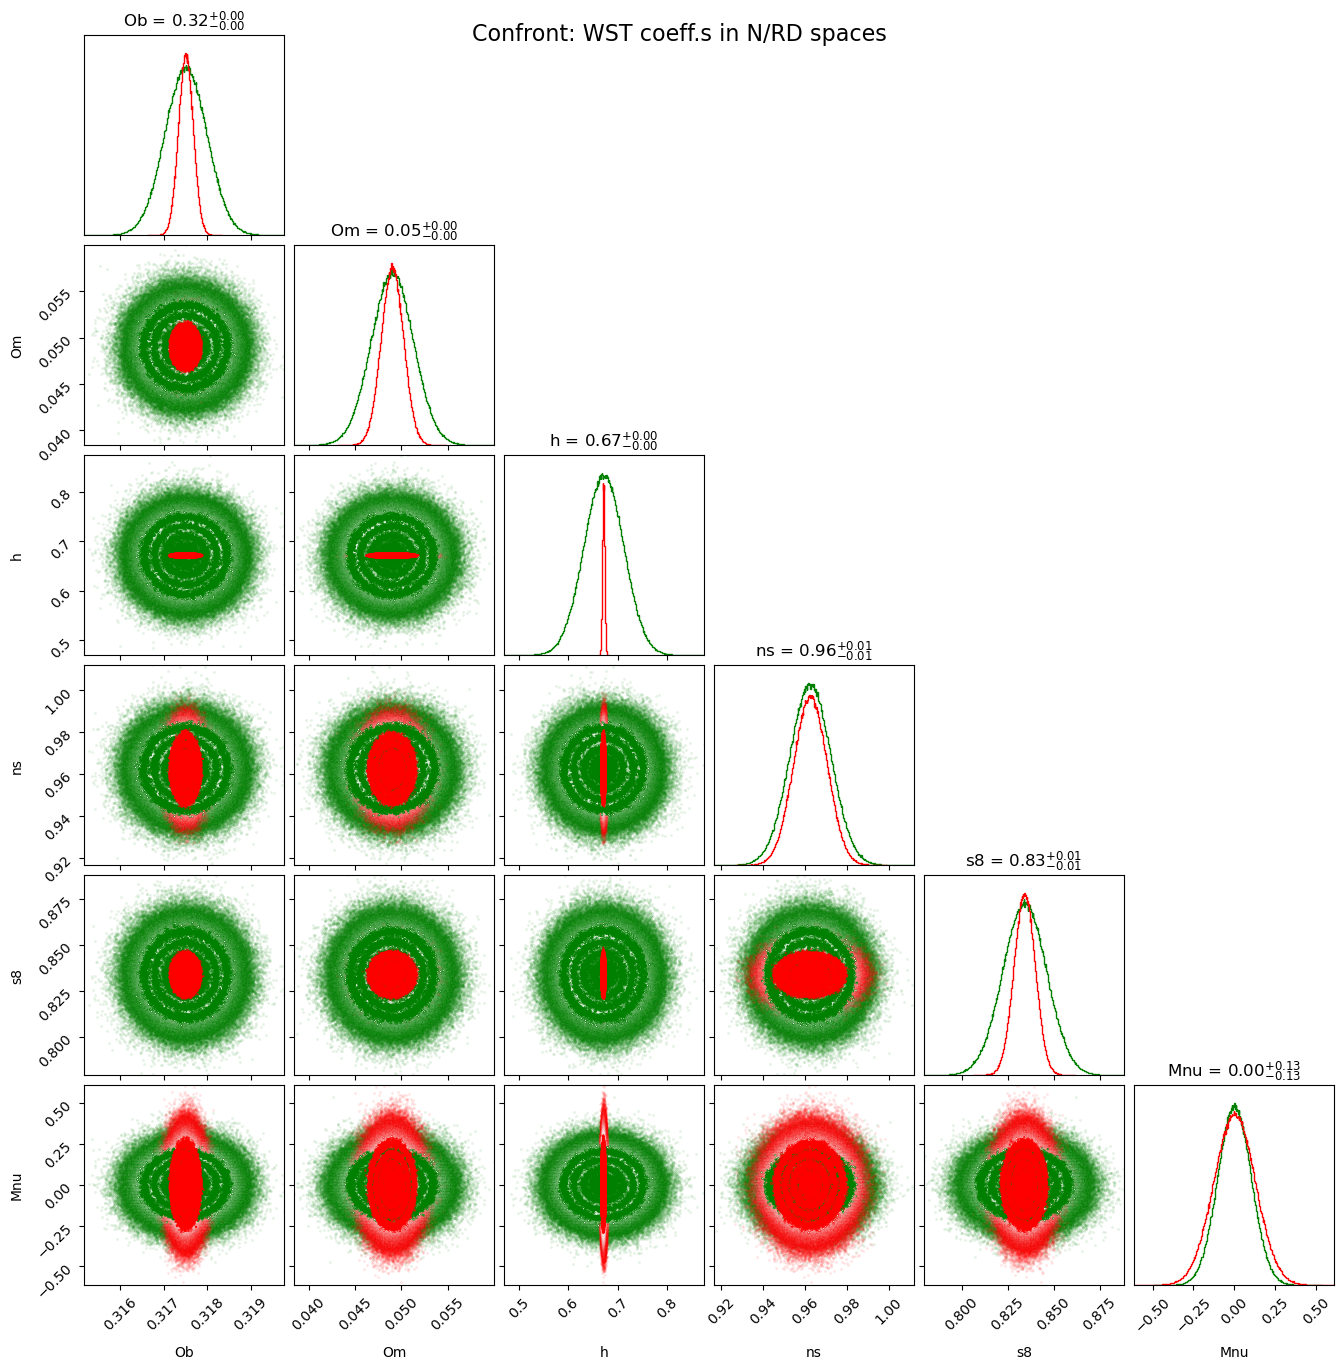

<Figure size 640x480 with 0 Axes>

In [31]:
figure1 = corner.corner(data_N_wst, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       )

corner.corner(data_RD_wst, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure1)

figure1.suptitle('Confront: WST coeff.s in N/RD spaces', fontsize=16)
# plt.figtext(0.25, 0.95, "Corner data_N_wst", fontsize=14, ha="center")
# plt.figtext(0.75, 0.95, "Corner data_RD_wst", fontsize=14, ha="center")
plt.show()
plt.savefig("WST_coeffs_N_RD.pdf")

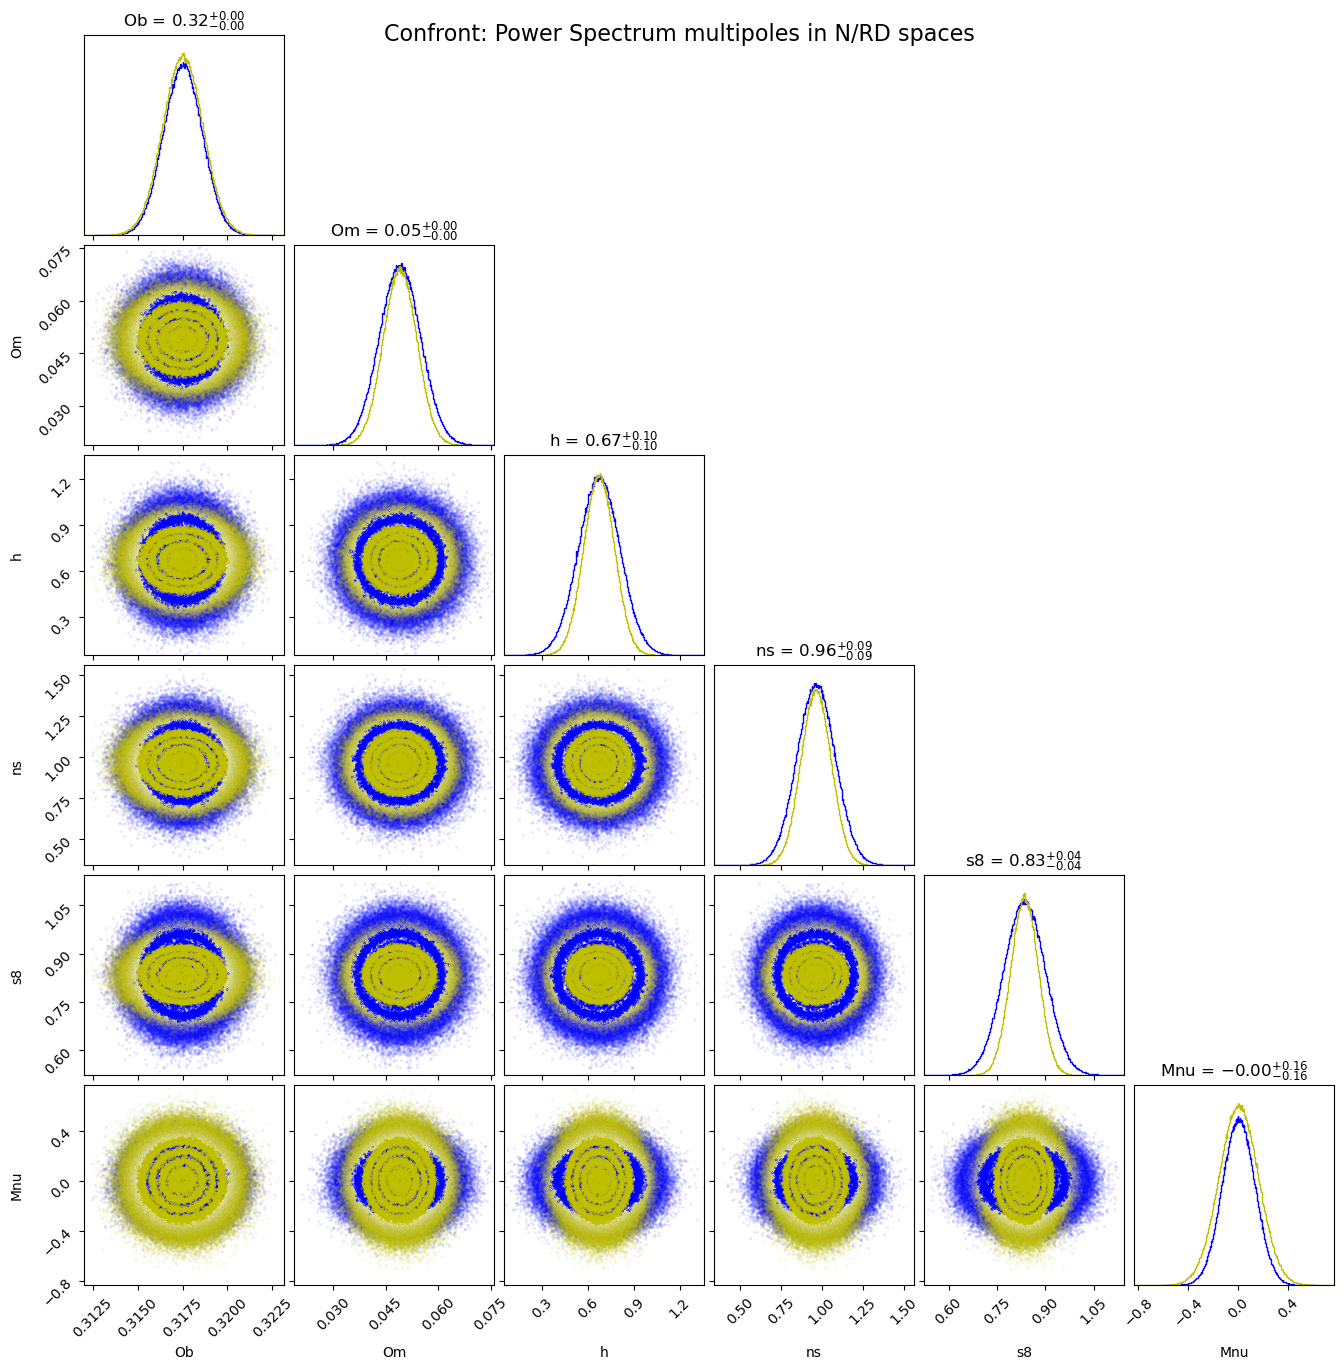

In [32]:
figure2 = corner.corner(data_N_multi, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='b',
                       # hist_kwargs={"color": "b"}, contour_kwargs={"colors": "b"}
                       )
corner.corner(data_RD_multi, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='y',
                       # hist_kwargs={"color": "y"}, contour_kwargs={"colors": "y"},
                       fig=figure2)

figure2.suptitle('Confront: Power Spectrum multipoles in N/RD spaces', fontsize=16)
plt.savefig("PK_coeffs_N_RD.pdf")
plt.show();

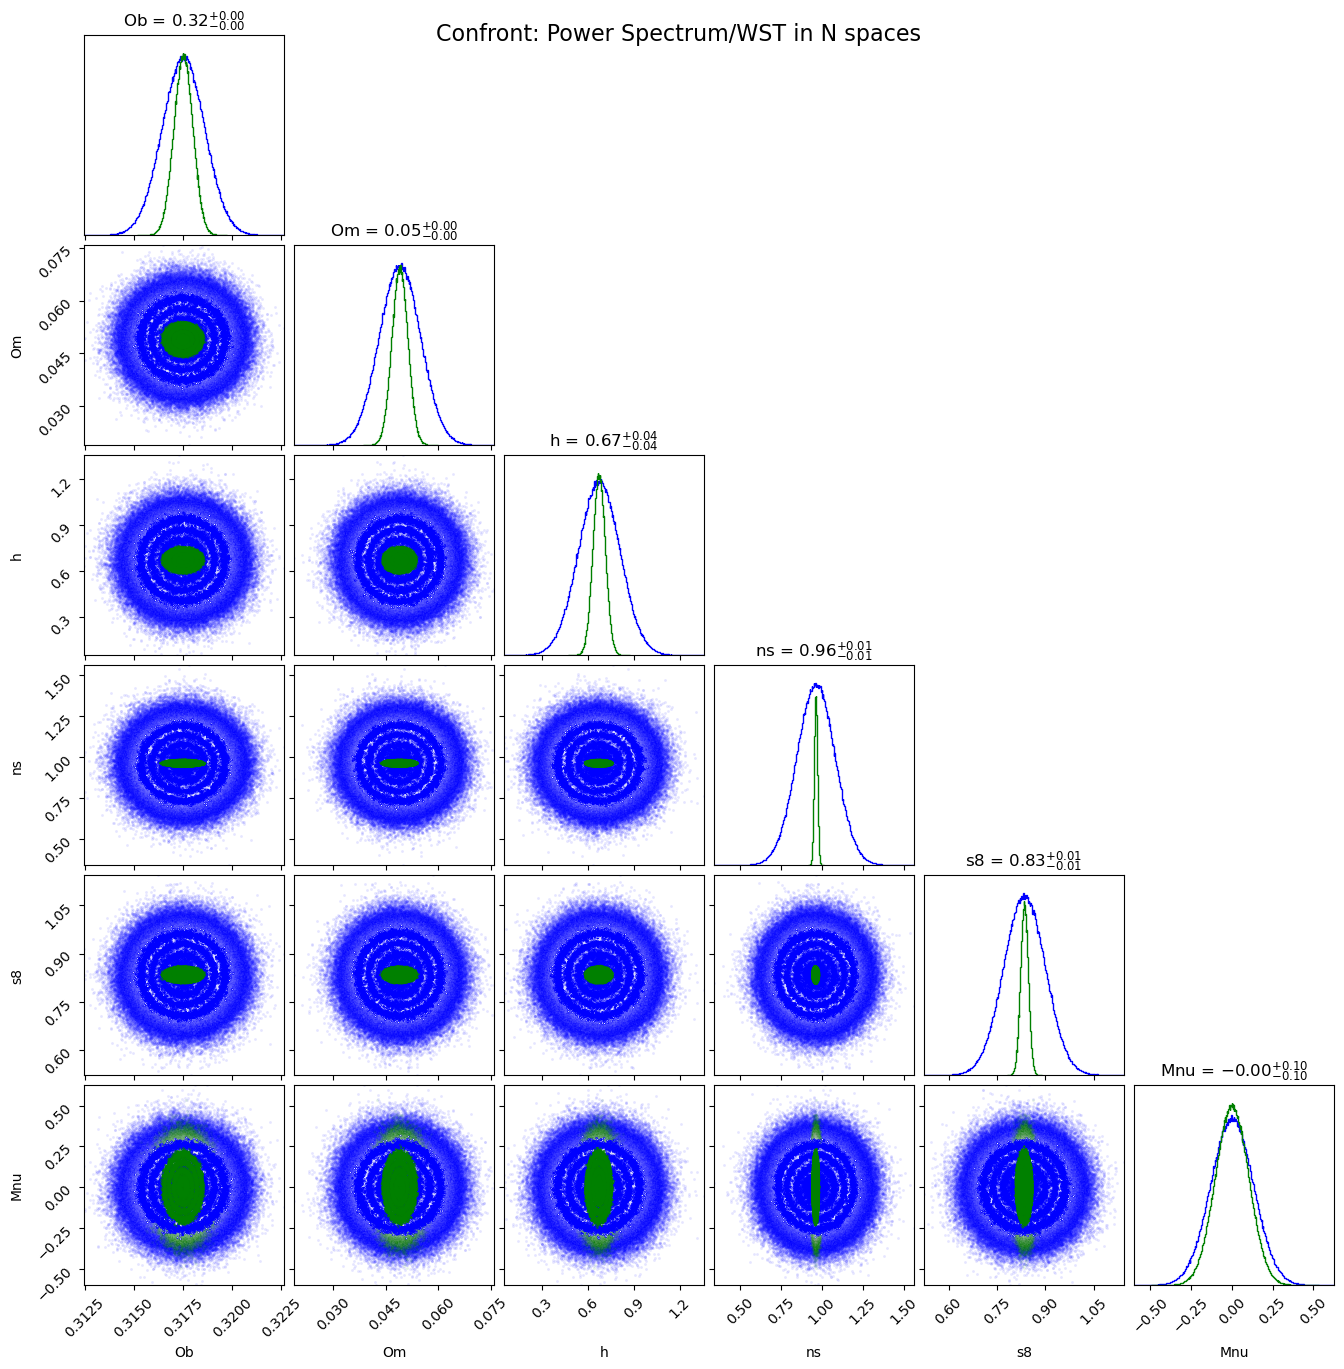

In [33]:
figure3 = corner.corner(data_N_multi, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='b', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "b"}
                       )
corner.corner(data_N_wst, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"},
                       fig=figure3
                       )

figure3.suptitle('Confront: Power Spectrum/WST in N spaces', fontsize=16)
plt.savefig("WST_PK_coeffs_N.pdf")
plt.show();

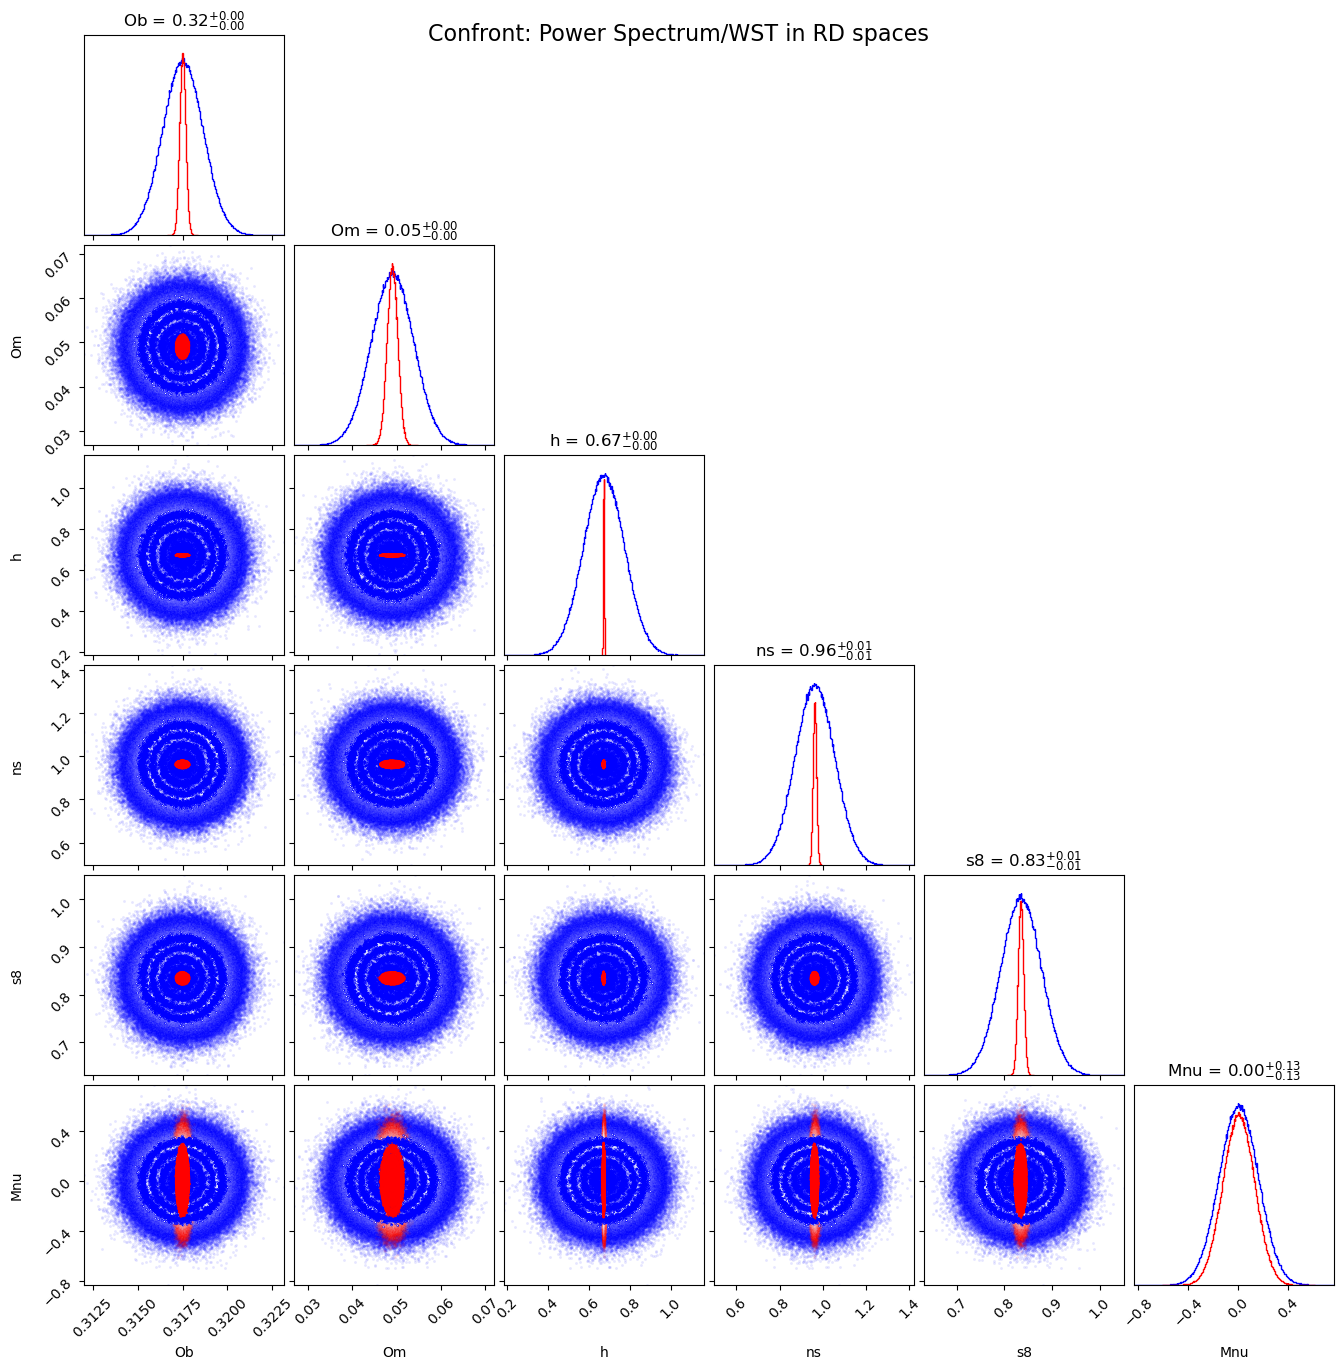

In [31]:
figure4 = corner.corner(data_RD_multi, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='b', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "b"}
                       )
corner.corner(data_RD_wst, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure4)

figure4.suptitle('Confront: Power Spectrum/WST in RD spaces', fontsize=16)
plt.savefig("WST_PK_coeffs_RD.pdf")
plt.show();

import os

import numpy as np

root_pk = "/media/fuffolo97/HDD1/UNI/Tesi/Pk-files_08_08"

files_to_read_raw_pk = os.listdir(root_pk)

files_to_read_N_pk = []

files_to_read_RD_pk = []

monos_tot_N_pk = np.zeros((len(cosmologies), 221))
quads_tot_N_pk = np.zeros((len(cosmologies), 221))
multi_tot_N_pk = np.zeros((len(cosmologies), 221*2))
monos_tot_RD_pk = np.zeros((len(cosmologies), 221))
quads_tot_RD_pk = np.zeros((len(cosmologies), 221))
multi_tot_RD_pk = np.zeros((len(cosmologies), 221*2))
fiducial_mono_N_coeffs = []
fiducial_quad_N_coeffs = []
fiducial_multi_N = []
zeldovich_mono_N_coeffs = []
zeldovich_quad_N_coeffs = []
zeldovich_multi_N = []
fiducial_mono_RD_coeffs = []
fiducial_quad_RD_coeffs = []
fiducial_multi_RD = []
zeldovich_mono_RD_coeffs = []
zeldovich_quad_RD_coeffs = []
zeldovich_multi_RD = []

for i in range(len(files_to_read_raw_pk)):
    if "_Ns_"   in files_to_read_raw_pk[i] and "400" not in  files_to_read_raw_pk[i] and "_Pk_M_" in files_to_read_raw_pk[i]: files_to_read_N_pk.append(files_to_read_raw_pk[i])
    if "_RDs_" in files_to_read_raw_pk[i]  and "400" not in  files_to_read_raw_pk[i] and "_Pk_M_" in files_to_read_raw_pk[i]: files_to_read_RD_pk.append(files_to_read_raw_pk[i])

for i in range(len(files_to_read_N_pk)):
    coeffs_cosm_pk = []
    file_reading = files_to_read_N_pk[i]

    monopoles = []
    quadrupoles = []
    multipoles = []

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]

    assert (cosmo != "fiducial" and cosmo != "zeldovich") == (("fiducial" not in file_reading) and ("zeldovich" not in file_reading))
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    monopoles.append(a[:,0])
                    assert np.shape(a[:,0]) == (221,), f"it's {np.shape(a[:,0])}"
                    quadrupoles.append(a[:,1])
                    assert np.shape(a[:,1]) == (221,), f"it's {np.shape(a[:,1])}"

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    multipoles.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(np.shape(multipoles))
        assert np.shape(np.average(monopoles, axis=0)) == (221,)
        assert np.shape(np.average(quadrupoles, axis=0)) == (221,)
        assert np.shape(np.average(multipoles, axis=0)) == (442,)

    elif "fiducial" in file_reading:
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    fiducial_mono_N_coeffs.append(a[:,0])
                    fiducial_quad_N_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    fiducial_multi_N.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_mono_N_avg = np.average(fiducial_mono_N_coeffs, axis=0)
        fiducial_quad_N_avg = np.average(fiducial_quad_N_coeffs, axis=0)
        fiducial_multi_N_avg = np.average(fiducial_multi_N, axis=0)

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    zeldovich_mono_N_coeffs.append(a[:,0])
                    zeldovich_quad_N_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    zeldovich_multi_N.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        zeldovich_mono_N_avg = np.average(zeldovich_mono_N_coeffs, axis=0)
        zeldovich_quad_N_avg = np.average(zeldovich_quad_N_coeffs, axis=0)
        zeldovich_multi_N_avg = np.average(zeldovich_multi_N, axis=0)
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(monopoles) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(monopoles))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        #assert len(monopoles) == (221,), "wronng length for monopoles array"
        monos_tot_N_pk[index] = np.average(monopoles, axis=0)
        quads_tot_N_pk[index] = np.average(quadrupoles, axis=0)
        multi_tot_N_pk[index] = np.average(multipoles, axis=0)


for i in range(len(files_to_read_RD_pk)):
    coeffs_cosm_pk = []
    file_reading = files_to_read_RD_pk[i]

    monopoles = []
    quadrupoles = []
    multipoles = []

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]

    assert (cosmo != "fiducial" and cosmo != "zeldovich") == (("fiducial" not in file_reading) and ("zeldovich" not in file_reading))
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    monopoles.append(a[:,0])
                    assert np.shape(a[:,0]) == (221,), f"it's {np.shape(a[:,0])}"
                    quadrupoles.append(a[:,1])
                    assert np.shape(a[:,1]) == (221,), f"it's {np.shape(a[:,1])}"

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    multipoles.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(np.shape(multipoles))
        assert np.shape(np.average(monopoles, axis=0)) == (221,)
        assert np.shape(np.average(quadrupoles, axis=0)) == (221,)
        assert np.shape(np.average(multipoles, axis=0)) == (442,)

    elif "fiducial" in file_reading:
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    fiducial_mono_RD_coeffs.append(a[:,0])
                    fiducial_quad_RD_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    fiducial_multi_RD.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_mono_RD_avg = np.average(fiducial_mono_RD_coeffs, axis=0)
        fiducial_quad_RD_avg = np.average(fiducial_quad_RD_coeffs, axis=0)
        fiducial_multi_RD_avg = np.average(fiducial_multi_RD, axis=0)

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    zeldovich_mono_RD_coeffs.append(a[:,0])
                    zeldovich_quad_RD_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    zeldovich_multi_RD.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        zeldovich_mono_RD_avg = np.average(zeldovich_mono_RD_coeffs, axis=0)
        zeldovich_quad_RD_avg = np.average(zeldovich_quad_RD_coeffs, axis=0)
        zeldovich_multi_RD_avg = np.average(zeldovich_multi_RD, axis=0)
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(monopoles) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(monopoles))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        #assert len(monopoles) == (221,), "wronng length for monopoles array"
        monos_tot_RD_pk[index] = np.average(monopoles, axis=0)
        quads_tot_RD_pk[index] = np.average(quadrupoles, axis=0)
        multi_tot_RD_pk[index] = np.average(multipoles, axis=0)

assert np.shape(monos_tot_RD_pk[0]) == (221,)
assert np.shape(quads_tot_RD_pk[0]) == (221,)
assert np.shape(multi_tot_RD_pk[0]) == (442,)